# **Predict Health Outcomes of Horses**
This is for kaggle competition, for more info do visit this [link](https://www.kaggle.com/competitions/playground-series-s3e22/overview).

- Author: Santanu Kundu

## **Index**

1. [Downloading data and importing library](#1)
1. [Overview of Train Data and Test Data](#1)
1.

## **Downloading data and importing library** <a name='1'></a>

In [ ]:
import os, json, IPython
project_name = "playground-series-s3e22"
token = {"username":"santanukundu","key":"de462df622bbe0817a45f17f3c1373eb"}
os.environ['KAGGLE_CONFIG_DIR']='.'
with open('kaggle.json', "w") as f:
    json.dump(token, f)
!chmod 600 ./kaggle.json
!kaggle competitions download -c $project_name
project_name += ".zip"
!unzip $project_name && rm $project_name
IPython.display.clear_output()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import plotly.express as px
import plotly.offline as pyo
pyo.init_notebook_mode()

from scipy.stats import anderson,kstest, shapiro
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, f1_score, recall_score

Output hidden; open in https://colab.research.google.com to view.

## **Overview of Train Data and Test Data** <a name='2'></a>

In [ ]:
# Some variables
percentiles = [ .1, .2, .25, .5, .68, .75, .8, .9, .98]

In [ ]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [ ]:
train_df.shape

(1235, 29)

In [ ]:
test_df.shape

(824, 28)

In [ ]:
# Percentage of Data need to be predicted
len(test_df)/len(train_df)

0.6672064777327935

In [ ]:
columns =  train_df.columns
columns

Index(['id', 'surgery', 'age', 'hospital_number', 'rectal_temp', 'pulse',
       'respiratory_rate', 'temp_of_extremities', 'peripheral_pulse',
       'mucous_membrane', 'capillary_refill_time', 'pain', 'peristalsis',
       'abdominal_distention', 'nasogastric_tube', 'nasogastric_reflux',
       'nasogastric_reflux_ph', 'rectal_exam_feces', 'abdomen',
       'packed_cell_volume', 'total_protein', 'abdomo_appearance',
       'abdomo_protein', 'surgical_lesion', 'lesion_1', 'lesion_2', 'lesion_3',
       'cp_data', 'outcome'],
      dtype='object')

In [ ]:
train_df.tail()

,id,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,...,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data,outcome
1230,1230,yes,adult,535246,38.5,129.0,48.0,cool,reduced,pale_pink,...,57.0,66.0,serosanguious,2.0,yes,2206,0,0,no,lived
1231,1231,yes,adult,528570,37.5,60.0,50.0,cool,reduced,pale_cyanotic,...,35.0,6.4,serosanguious,3.6,yes,2209,0,0,yes,died
1232,1232,yes,young,529685,37.5,84.0,40.0,normal,reduced,normal_pink,...,40.0,5.9,cloudy,7.0,yes,400,0,0,yes,lived
1233,1233,yes,adult,534784,38.1,70.0,16.0,normal,reduced,bright_red,...,58.0,74.0,cloudy,2.0,yes,2209,0,0,no,lived
1234,1234,yes,adult,528548,38.1,54.0,36.0,normal,normal,pale_pink,...,45.0,6.0,clear,3.6,yes,2124,0,0,yes,lived


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1235 entries, 0 to 1234
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     1235 non-null   int64  
 1   surgery                1235 non-null   object 
 2   age                    1235 non-null   object 
 3   hospital_number        1235 non-null   int64  
 4   rectal_temp            1235 non-null   float64
 5   pulse                  1235 non-null   float64
 6   respiratory_rate       1235 non-null   float64
 7   temp_of_extremities    1235 non-null   object 
 8   peripheral_pulse       1235 non-null   object 
 9   mucous_membrane        1235 non-null   object 
 10  capillary_refill_time  1235 non-null   object 
 11  pain                   1235 non-null   object 
 12  peristalsis            1235 non-null   object 
 13  abdominal_distention   1235 non-null   object 
 14  nasogastric_tube       1235 non-null   object 
 15  naso

In [ ]:
train_df.isnull().sum()/len(train_df)

id                       0.0
surgery                  0.0
age                      0.0
hospital_number          0.0
rectal_temp              0.0
pulse                    0.0
respiratory_rate         0.0
temp_of_extremities      0.0
peripheral_pulse         0.0
mucous_membrane          0.0
capillary_refill_time    0.0
pain                     0.0
peristalsis              0.0
abdominal_distention     0.0
nasogastric_tube         0.0
nasogastric_reflux       0.0
nasogastric_reflux_ph    0.0
rectal_exam_feces        0.0
abdomen                  0.0
packed_cell_volume       0.0
total_protein            0.0
abdomo_appearance        0.0
abdomo_protein           0.0
surgical_lesion          0.0
lesion_1                 0.0
lesion_2                 0.0
lesion_3                 0.0
cp_data                  0.0
outcome                  0.0
dtype: float64

In [ ]:
test_df.isnull().sum()

id                       0
surgery                  0
age                      0
hospital_number          0
rectal_temp              0
pulse                    0
respiratory_rate         0
temp_of_extremities      0
peripheral_pulse         0
mucous_membrane          0
capillary_refill_time    0
pain                     0
peristalsis              0
abdominal_distention     0
nasogastric_tube         0
nasogastric_reflux       0
nasogastric_reflux_ph    0
rectal_exam_feces        0
abdomen                  0
packed_cell_volume       0
total_protein            0
abdomo_appearance        0
abdomo_protein           0
surgical_lesion          0
lesion_1                 0
lesion_2                 0
lesion_3                 0
cp_data                  0
dtype: int64

- No missing data in train and test data.

In [ ]:
categorical_features = train_df.select_dtypes(include=['object']).columns
numerical_features = train_df.select_dtypes(exclude=['object']).columns

In [ ]:
len(categorical_features), len(numerical_features)

(17, 12)

In [ ]:
train_df[numerical_features].describe(percentiles = percentiles).T

,count,mean,std,min,10%,20%,25%,50%,68%,75%,80%,90%,98%,max
id,1235.0,617.000000,3.566581e+02,0.0,123.4,246.8,308.5,617.0,839.12,925.5,987.2,1110.6,1209.320,1234.0
hospital_number,1235.0,954500.401619,1.356403e+06,521399.0,528178.0,528630.0,528800.0,529777.0,533696.00,534145.0,534753.6,535330.0,5295377.400,5305129.0
rectal_temp,1235.0,38.202186,7.886678e-01,35.4,37.2,37.6,37.8,38.2,38.40,38.6,38.7,39.3,40.300,40.8
pulse,1235.0,79.574089,2.910864e+01,30.0,48.0,52.0,53.0,76.0,90.00,100.0,108.0,114.0,153.200,184.0
respiratory_rate,1235.0,30.054251,1.645207e+01,8.0,12.0,16.0,18.0,28.0,36.00,36.0,40.0,48.0,84.000,96.0
nasogastric_reflux_ph,1235.0,4.382591,1.937357e+00,1.0,2.0,2.0,2.0,4.5,5.50,6.0,6.5,7.0,7.064,7.5
packed_cell_volume,1235.0,49.602429,1.053580e+01,23.0,37.0,41.0,43.0,48.0,53.00,57.0,57.0,66.0,75.000,75.0
total_protein,1235.0,21.388016,2.667645e+01,3.5,6.0,6.5,6.6,7.5,8.10,9.1,56.2,74.0,82.000,89.0
abdomo_protein,1235.0,3.290931,1.589195e+00,0.1,2.0,2.0,2.0,3.0,3.90,4.3,4.5,5.2,7.400,10.1
lesion_1,1235.0,3832.496356,5.436734e+03,0.0,1400.0,2124.0,2205.0,2209.0,3133.00,3205.0,4205.0,7111.0,31110.000,41110.0


In [ ]:
train_df[ (train_df['lesion_2']!=0) | (train_df['lesion_3']!=0)]

,id,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,...,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data,outcome
43,43,yes,adult,535196,38.0,130.0,16.0,cool,reduced,pale_cyanotic,...,52.0,65.0,serosanguious,2.0,no,3205,1400,0,no,euthanized
58,58,yes,adult,533887,38.2,88.0,24.0,cool,reduced,bright_pink,...,66.0,64.0,serosanguious,2.0,yes,4205,3111,2209,no,euthanized
76,76,no,adult,529427,37.5,88.0,24.0,normal,reduced,bright_red,...,69.0,8.2,cloudy,5.0,no,3111,3112,0,yes,lived
105,105,no,adult,5283431,38.0,54.0,24.0,normal,normal,normal_pink,...,41.0,7.5,clear,6.0,no,3112,3112,0,yes,lived
311,311,no,adult,534293,38.2,130.0,48.0,cold,reduced,pale_cyanotic,...,65.0,82.0,cloudy,2.0,no,2209,1400,0,yes,euthanized
523,523,yes,adult,535163,37.8,78.0,20.0,cool,reduced,pale_pink,...,37.0,66.0,None,2.0,yes,2207,1400,0,no,euthanized
705,705,yes,adult,528461,38.0,112.0,44.0,cool,reduced,pale_cyanotic,...,60.0,6.1,cloudy,2.8,yes,4205,3111,2209,yes,lived
1015,1015,yes,adult,534787,38.2,36.0,16.0,cool,normal,bright_pink,...,52.0,75.0,cloudy,2.0,yes,2209,1400,0,no,euthanized


In [ ]:
# Target variables
train_df['outcome'].value_counts()

lived         574
died          410
euthanized    251
Name: outcome, dtype: int64

In [ ]:
train_df['age'].value_counts()

adult    1160
young      75
Name: age, dtype: int64

In [ ]:
train_df[['age', 'outcome', 'id']].groupby(['age', 'outcome']).count().reset_index()

,age,outcome,id
0,adult,died,356
1,adult,euthanized,248
2,adult,lived,556
3,young,died,54
4,young,euthanized,3
5,young,lived,18


In [ ]:
train_df[categorical_features].nunique()

surgery                  2
age                      2
temp_of_extremities      5
peripheral_pulse         5
mucous_membrane          7
capillary_refill_time    4
pain                     7
peristalsis              6
abdominal_distention     5
nasogastric_tube         4
nasogastric_reflux       5
rectal_exam_feces        6
abdomen                  6
abdomo_appearance        4
surgical_lesion          2
cp_data                  2
outcome                  3
dtype: int64

In [ ]:
train_df[numerical_features].nunique()

id                       1235
hospital_number           255
rectal_temp                43
pulse                      50
respiratory_rate           37
nasogastric_reflux_ph      26
packed_cell_volume         49
total_protein              83
abdomo_protein             54
lesion_1                   57
lesion_2                    4
lesion_3                    2
dtype: int64

In [ ]:
test_df[numerical_features].nunique()

id                       824
hospital_number          210
rectal_temp               34
pulse                     49
respiratory_rate          38
nasogastric_reflux_ph     29
packed_cell_volume        48
total_protein             72
abdomo_protein            50
lesion_1                  54
lesion_2                   4
lesion_3                   1
dtype: int64

In [ ]:
train_df[['lesion_2', 'lesion_3']].drop_duplicates()

,lesion_2,lesion_3
0,0,0
43,1400,0
58,3111,2209
76,3112,0


In [ ]:
test_df[['lesion_2', 'lesion_3']].drop_duplicates()

,lesion_2,lesion_3
0,0,0
135,3111,0
393,1400,0
669,4300,0


In [ ]:
train_df['surgical_lesion'].value_counts()

yes    929
no     306
Name: surgical_lesion, dtype: int64

In [ ]:
# train_df['lesion_1'].value_counts()

In [ ]:
train_df[ (train_df['lesion_2']!=0) | (train_df['lesion_3']!=0)]

,id,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,...,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data,outcome
43,43,yes,adult,535196,38.0,130.0,16.0,cool,reduced,pale_cyanotic,...,52.0,65.0,serosanguious,2.0,no,3205,1400,0,no,euthanized
58,58,yes,adult,533887,38.2,88.0,24.0,cool,reduced,bright_pink,...,66.0,64.0,serosanguious,2.0,yes,4205,3111,2209,no,euthanized
76,76,no,adult,529427,37.5,88.0,24.0,normal,reduced,bright_red,...,69.0,8.2,cloudy,5.0,no,3111,3112,0,yes,lived
105,105,no,adult,5283431,38.0,54.0,24.0,normal,normal,normal_pink,...,41.0,7.5,clear,6.0,no,3112,3112,0,yes,lived
311,311,no,adult,534293,38.2,130.0,48.0,cold,reduced,pale_cyanotic,...,65.0,82.0,cloudy,2.0,no,2209,1400,0,yes,euthanized
523,523,yes,adult,535163,37.8,78.0,20.0,cool,reduced,pale_pink,...,37.0,66.0,None,2.0,yes,2207,1400,0,no,euthanized
705,705,yes,adult,528461,38.0,112.0,44.0,cool,reduced,pale_cyanotic,...,60.0,6.1,cloudy,2.8,yes,4205,3111,2209,yes,lived
1015,1015,yes,adult,534787,38.2,36.0,16.0,cool,normal,bright_pink,...,52.0,75.0,cloudy,2.0,yes,2209,1400,0,no,euthanized


In [ ]:
test_df[ (test_df['lesion_2']!=0) | (test_df['lesion_3']!=0)]

,id,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,...,abdomen,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data
135,1370,yes,adult,535208,37.8,48.0,16.0,normal,reduced,normal_pink,...,distend_large,42.0,75.0,serosanguious,2.0,yes,3111,3111,0,no
393,1628,yes,adult,534293,38.2,132.0,16.0,cold,reduced,pale_cyanotic,...,None,65.0,82.0,cloudy,2.0,no,1400,1400,0,no
411,1646,yes,adult,534145,38.1,60.0,32.0,None,None,None,...,None,55.0,75.0,serosanguious,2.0,no,0,1400,0,no
669,1904,yes,adult,534998,39.4,88.0,36.0,cool,reduced,pale_pink,...,distend_small,53.0,74.0,serosanguious,2.0,yes,1400,4300,0,no


In [ ]:
x1 = train_df[['lesion_1', 'outcome', 'id']]
x1.columns = ['lesion', 'outcome', 'id']
x2 = train_df[['lesion_2', 'outcome', 'id']]
x2.columns = ['lesion', 'outcome', 'id']
x3 = train_df[['lesion_3', 'outcome', 'id']]
x3.columns = ['lesion', 'outcome', 'id']
x = pd.concat([x1, x2, x3])

In [ ]:
x.groupby(['lesion', 'outcome']).count().reset_index()

,lesion,outcome,id
0,0,died,824
1,0,euthanized,500
2,0,lived,1230
3,300,died,1
4,300,lived,1
...,...,...,...
120,21110,euthanized,1
121,31110,died,7
122,31110,euthanized,4
123,31110,lived,28


In [ ]:
train_df.head().T

,0,1,2,3,4
id,0,1,2,3,4
surgery,yes,yes,yes,yes,no
age,adult,adult,adult,adult,adult
hospital_number,530001,533836,529812,5262541,5299629
rectal_temp,38.1,37.5,38.3,37.1,38.0
pulse,132.0,88.0,120.0,72.0,52.0
respiratory_rate,24.0,12.0,28.0,30.0,48.0
temp_of_extremities,cool,cool,cool,cold,normal
peripheral_pulse,reduced,normal,reduced,reduced,normal
mucous_membrane,dark_cyanotic,pale_cyanotic,pale_pink,pale_pink,normal_pink


In [ ]:
train_df[categorical_features]

,surgery,age,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,pain,peristalsis,abdominal_distention,nasogastric_tube,nasogastric_reflux,rectal_exam_feces,abdomen,abdomo_appearance,surgical_lesion,cp_data,outcome
0,yes,adult,cool,reduced,dark_cyanotic,more_3_sec,depressed,absent,slight,slight,less_1_liter,decreased,distend_small,serosanguious,yes,no,died
1,yes,adult,cool,normal,pale_cyanotic,more_3_sec,mild_pain,absent,moderate,none,more_1_liter,absent,distend_small,serosanguious,yes,no,euthanized
2,yes,adult,cool,reduced,pale_pink,less_3_sec,extreme_pain,hypomotile,moderate,slight,none,None,distend_large,serosanguious,yes,no,lived
3,yes,adult,cold,reduced,pale_pink,more_3_sec,mild_pain,hypomotile,moderate,slight,more_1_liter,decreased,distend_small,cloudy,yes,yes,lived
4,no,adult,normal,normal,normal_pink,less_3_sec,alert,hypomotile,none,slight,less_1_liter,normal,normal,cloudy,no,yes,lived
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1230,yes,adult,cool,reduced,pale_pink,more_3_sec,depressed,absent,moderate,none,more_1_liter,None,distend_large,serosanguious,yes,no,lived
1231,yes,adult,cool,reduced,pale_cyanotic,less_3_sec,mild_pain,hypomotile,slight,slight,none,decreased,distend_small,serosanguious,yes,yes,died
1232,yes,young,normal,reduced,normal_pink,less_3_sec,mild_pain,hypomotile,slight,slight,none,increased,firm,cloudy,yes,yes,lived
1233,yes,adult,normal,reduced,bright_red,less_3_sec,mild_pain,hypomotile,slight,none,more_1_liter,absent,distend_small,cloudy,yes,no,lived


In [ ]:
for i in categorical_features:
    print(f"{i}: {list(train_df[i].unique())}")

surgery: ['yes', 'no']
age: ['adult', 'young']
temp_of_extremities: ['cool', 'cold', 'normal', 'warm', 'None']
peripheral_pulse: ['reduced', 'normal', 'None', 'absent', 'increased']
mucous_membrane: ['dark_cyanotic', 'pale_cyanotic', 'pale_pink', 'normal_pink', 'bright_pink', 'bright_red', 'None']
capillary_refill_time: ['more_3_sec', 'less_3_sec', 'None', '3']
pain: ['depressed', 'mild_pain', 'extreme_pain', 'alert', 'severe_pain', 'None', 'slight']
peristalsis: ['absent', 'hypomotile', 'normal', 'hypermotile', 'None', 'distend_small']
abdominal_distention: ['slight', 'moderate', 'none', 'severe', 'None']
nasogastric_tube: ['slight', 'none', 'significant', 'None']
nasogastric_reflux: ['less_1_liter', 'more_1_liter', 'none', 'None', 'slight']
rectal_exam_feces: ['decreased', 'absent', 'None', 'normal', 'increased', 'serosanguious']
abdomen: ['distend_small', 'distend_large', 'normal', 'firm', 'None', 'other']
abdomo_appearance: ['serosanguious', 'cloudy', 'clear', 'None']
surgical_lesi

In [ ]:
train_df.isnull().sum()

id                       0
surgery                  0
age                      0
hospital_number          0
rectal_temp              0
pulse                    0
respiratory_rate         0
temp_of_extremities      0
peripheral_pulse         0
mucous_membrane          0
capillary_refill_time    0
pain                     0
peristalsis              0
abdominal_distention     0
nasogastric_tube         0
nasogastric_reflux       0
nasogastric_reflux_ph    0
rectal_exam_feces        0
abdomen                  0
packed_cell_volume       0
total_protein            0
abdomo_appearance        0
abdomo_protein           0
surgical_lesion          0
lesion_1                 0
lesion_2                 0
lesion_3                 0
cp_data                  0
outcome                  0
dtype: int64

In [ ]:
mapper = {}
df_train = train_df.copy()
df_test = test_df.copy()
for i in categorical_features:
    mapper[i] = dict(zip(train_df[i].unique(), range(train_df[i].nunique())))
    df_train[i] = df_train[i].map(mapper[i])
    if i!='outcome':
        df_test[i] = df_test[i].map(mapper[i])


In [ ]:
df_train.head()

,id,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,...,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data,outcome
0,0,0,0,530001,38.1,132.0,24.0,0,0,0,...,57.0,8.5,0,3.4,0,2209,0,0,0,0
1,1,0,0,533836,37.5,88.0,12.0,0,1,1,...,33.0,64.0,0,2.0,0,2208,0,0,0,1
2,2,0,0,529812,38.3,120.0,28.0,0,0,2,...,37.0,6.4,0,3.4,0,5124,0,0,0,2
3,3,0,0,5262541,37.1,72.0,30.0,1,0,2,...,53.0,7.0,1,3.9,0,2208,0,0,1,2
4,4,1,0,5299629,38.0,52.0,48.0,2,1,3,...,47.0,7.3,1,2.6,1,0,0,0,1,2


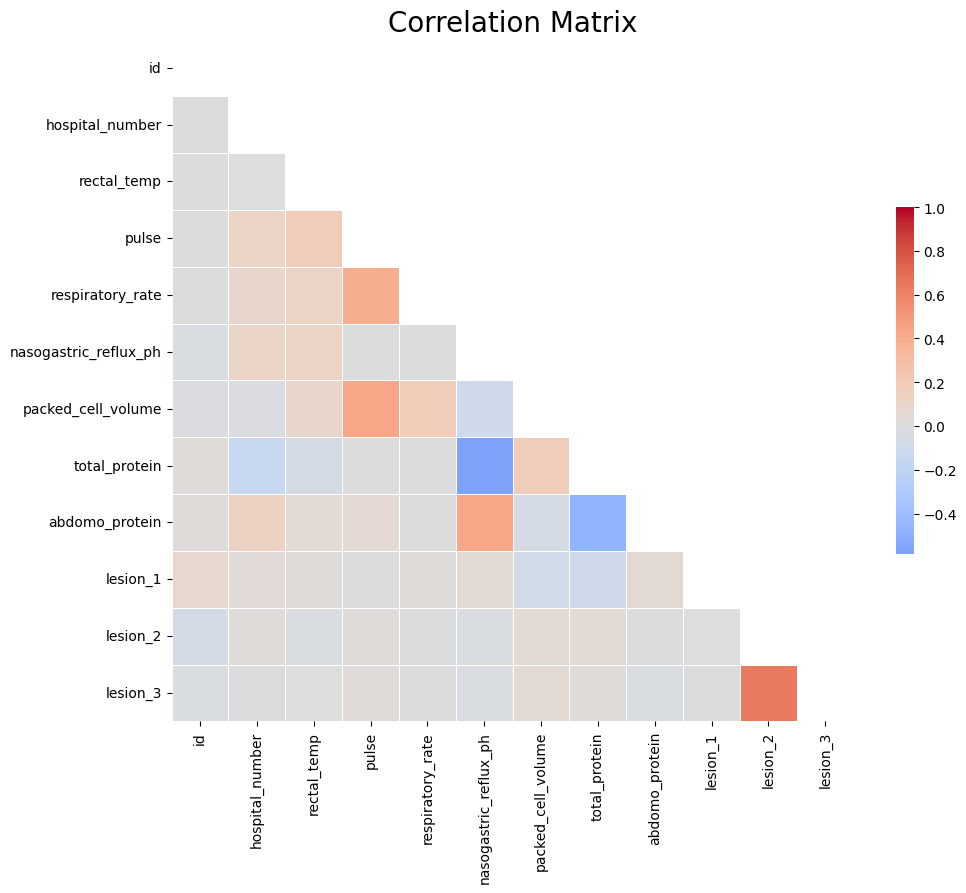

In [ ]:
corr = train_df[numerical_features].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap='coolwarm', vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Correlation Matrix', fontsize=20)
plt.savefig("Correlation matrix.png")
plt.show()

In [ ]:
train_df[['lesion_2', 'lesion_3']].drop_duplicates()

,lesion_2,lesion_3
0,0,0
43,1400,0
58,3111,2209
76,3112,0


In [ ]:
test_df[['lesion_2', 'lesion_3']].drop_duplicates()

,lesion_2,lesion_3
0,0,0
135,3111,0
393,1400,0
669,4300,0


In [ ]:
train_df[ (train_df['lesion_2']!=0) | (train_df['lesion_3']!=0)]

,id,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,...,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data,outcome
43,43,yes,adult,535196,38.0,130.0,16.0,cool,reduced,pale_cyanotic,...,52.0,65.0,serosanguious,2.0,no,3205,1400,0,no,euthanized
58,58,yes,adult,533887,38.2,88.0,24.0,cool,reduced,bright_pink,...,66.0,64.0,serosanguious,2.0,yes,4205,3111,2209,no,euthanized
76,76,no,adult,529427,37.5,88.0,24.0,normal,reduced,bright_red,...,69.0,8.2,cloudy,5.0,no,3111,3112,0,yes,lived
105,105,no,adult,5283431,38.0,54.0,24.0,normal,normal,normal_pink,...,41.0,7.5,clear,6.0,no,3112,3112,0,yes,lived
311,311,no,adult,534293,38.2,130.0,48.0,cold,reduced,pale_cyanotic,...,65.0,82.0,cloudy,2.0,no,2209,1400,0,yes,euthanized
523,523,yes,adult,535163,37.8,78.0,20.0,cool,reduced,pale_pink,...,37.0,66.0,None,2.0,yes,2207,1400,0,no,euthanized
705,705,yes,adult,528461,38.0,112.0,44.0,cool,reduced,pale_cyanotic,...,60.0,6.1,cloudy,2.8,yes,4205,3111,2209,yes,lived
1015,1015,yes,adult,534787,38.2,36.0,16.0,cool,normal,bright_pink,...,52.0,75.0,cloudy,2.0,yes,2209,1400,0,no,euthanized


In [ ]:
test_df[ (test_df['lesion_2']!=0) | (test_df['lesion_3']!=0)]

,id,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,...,abdomen,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data
135,1370,yes,adult,535208,37.8,48.0,16.0,normal,reduced,normal_pink,...,distend_large,42.0,75.0,serosanguious,2.0,yes,3111,3111,0,no
393,1628,yes,adult,534293,38.2,132.0,16.0,cold,reduced,pale_cyanotic,...,None,65.0,82.0,cloudy,2.0,no,1400,1400,0,no
411,1646,yes,adult,534145,38.1,60.0,32.0,None,None,None,...,None,55.0,75.0,serosanguious,2.0,no,0,1400,0,no
669,1904,yes,adult,534998,39.4,88.0,36.0,cool,reduced,pale_pink,...,distend_small,53.0,74.0,serosanguious,2.0,yes,1400,4300,0,no


In [ ]:
df_train.drop(['lesion_2', 'lesion_3', 'hospital_number'],axis=1, inplace=True)
df_test.drop(['lesion_2', 'lesion_3', 'hospital_number' ],axis=1, inplace=True)

In [ ]:
np.

In [ ]:
from sklearn.linear_model import LogisticRegression
y = df_train['outcome']
X = df_train.drop(['outcome'], axis=1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=.9, random_state=42)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
lr = LogisticRegression(multi_class='ovr')
lr.fit(X_train, y_train)

LogisticRegression(multi_class='ovr')

In [ ]:
y_train_pred = lr.predict(X_train)
confusion_matrix(y_train, y_train_pred)

array([[271,  11,  97],
       [ 45, 102,  67],
       [ 88,  41, 389]])

In [ ]:
accuracy_score(y_train, y_train_pred)

0.6858685868586859

In [ ]:
y_test_pred = lr.predict(X_test)
accuracy_score(y_test, y_test_pred)

0.5806451612903226

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(max_depth=5)
dt.fit(X_train, y_train)

y_train_pred = dt.predict(X_train)
f1_score(y_train, y_train_pred, average = 'micro')

0.7362736273627364

In [ ]:
y_test_pred = dt.predict(X_test)
f1_score(y_test, y_test_pred, average = 'micro')

0.6370967741935484

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
gb = GradientBoostingClassifier()
gb.fit(X_train,y_train)

y_train_pred = gb.predict(X_train)
f1_score(y_train, y_train_pred, average = 'micro')

0.9018901890189019

In [ ]:
y_test_pred = gb.predict(X_test)
f1_score(y_test, y_test_pred, average = 'micro')

0.7338709677419355

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train,y_train)

y_train_pred = rf.predict(X_train)
f1_score(y_train, y_train_pred, average = 'micro')

1.0

In [ ]:
y_test_pred = rf.predict(X_test)
f1_score(y_test, y_test_pred, average = 'micro')

0.6774193548387096

In [ ]:
 from sklearn.model_selection import make_scorer
params = {
'loss' : ['']
}
score = make_scorer(f1_score, average='micro')
grid = GridSearchCV(GradientBoostingClassifier(),params, scoring = score, n_jobs=-1, cv = 3)